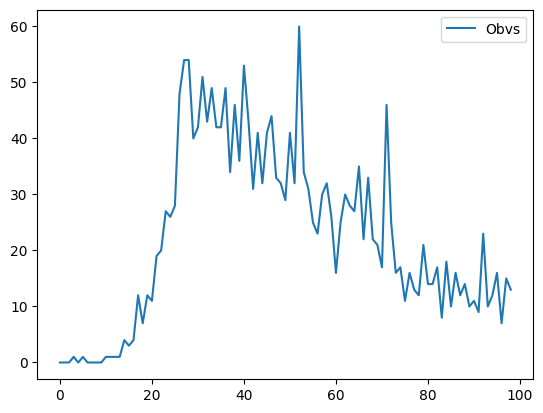

In [1]:
'''Testing static parameter estimation on different kinds of models'''

import sys
sys.path.append('../')
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import pandas as pd

beta_par = {'beta_0':0.4,'beta_inf':0.1,'T':20,'tau':5} #hyperparameters for the functional form of beta

def beta(t,beta_par):

    if(t<beta_par['T']):
        return beta_par['beta_0']

    return beta_par['beta_inf'] + (beta_par['beta_0'] - beta_par['beta_inf']) * np.exp(-(t-beta_par['T'])/beta_par['tau'])

beta_ts = np.linspace(0,100,100000)

betas = []
for i in range(np.shape(beta_ts)[0]):
    betas.append(beta(beta_ts[i],beta_par))


    

params={
"beta":lambda t: beta(t,beta_par),
"gamma":0.06,
"mu":0.004,
"q":0.1,
"eta":1/7,
"std":10,
"R":50,
"hosp":10,
"L":90,
"D":10,
}

def RHS_H(t,state,param):
    #params has all the parameters – beta, gamma
    #state is a numpy array

        S,I,R,H,new_H = state #unpack the state variables
        N = S + I + R + H #compute the total population 

        new_H = (1/param['D'])*(param['gamma']) * I

        '''The state transitions of the ODE model is below'''
        dS = -param['beta'](int(t))*(S*I)/N + (1/param['L'])*R 
        dI = param['beta'](int(t))*S*I/N-(1/param['D'])*I
        dR = (1/param['hosp']) * H + ((1/param['D'])*(1-(param['gamma']))*I)-(1/param['L'])*R 
        dH = (1/param['D'])*(param['gamma']) * I - (1/param['hosp']) * H 

        return np.array([dS,dI,dR,dH,new_H])

y0 = [100_000,5,0,0,0]

sol =  solve_ivp(fun=lambda t,z: RHS_H(t,z,params), 
                    t_span=[0,100],
                    t_eval=np.linspace(0,100,100),
                    y0=y0,
                    method='LSODA')

observations = np.diff(sol.y[4,:])
R = 50
for i in range(99): 
    observations[i] = np.random.negative_binomial(n = R,p = R/(observations[i]+R))


pd.DataFrame(observations).to_csv('../datasets/SIRH_SIM_DATA.csv')

labels = ['S','I','R','H','Obvs'] 
for i in range(4,4): 
    plt.plot(sol.y[i,:],label = labels[i])
plt.plot(observations,label = labels[4])
plt.legend()




In [2]:


from Implementations.algorithms.TimeDependentBeta import TimeDependentAlgo
from Implementations.resamplers.resamplers import PoissonResample,NBinomResample,LogNBinomResample
from Implementations.solvers.DeterministicSolvers import LSODACalvettiSolver,LSODASolver,LSODASolverSEIARHD
from Implementations.perturbers.perturbers import MultivariatePerturbations
from utilities.Utils import Context,ESTIMATION
from functools import partial

algo = TimeDependentAlgo(integrator = LSODASolver(),
                        perturb = MultivariatePerturbations(hyper_params={"h":0.9,"sigma1":0.01,"sigma2":0.1}),
                        resampler = LogNBinomResample(),
                        ctx=Context(population=100_000,
                                    state_size = 4,
                                    prior_weights=np.zeros(1000),
                                    pos_weights = np.zeros(1000),
                                    weight_ratio=np.ones(1000),
                                    seed_loc=[1],
                                    seed_size=0.005,
                                    forward_estimation=1,
                                    rng=np.random.default_rng(),
                        particle_count=1000))

algo.initialize(params={
"beta":ESTIMATION.VARIABLE,
"gamma":0.06,
"mu":0.004,
"q":0.1,
"eta":1/7,
"std":10,
"R":100,
"hosp":10,
"L":90,
"D":10,
}
,priors={"beta":partial(algo.ctx.rng.uniform,0.1,0.6), 
          "gamma":partial(algo.ctx.rng.uniform,0,1/7),
          "eta":partial(algo.ctx.rng.uniform,1/15,1/3),
          "hosp":partial(algo.ctx.rng.uniform,7.,15),
          "D":partial(algo.ctx.rng.uniform,5,12)
          })

'''Runs the PF over the specified data set for the specified length of time'''

#algo.print_particles()
algo.run(f'../datasets/SIRH_SIM_DATA.csv',99)



/Users/averydrennan/SMC_EPI/SMC_EPI/.venv/lib/python3.11/site-packages/scipy/integrate/_ivp/common.py:39: UserWarning: The following arguments have no effect for a chosen solver: `jac`.
  warn("The following arguments have no effect for a chosen solver: {}."


{'beta': 0.3536862813506971, 'gamma': 0.06, 'mu': 0.004, 'q': 0.1, 'eta': 0.14285714285714285, 'std': 10, 'R': 100, 'hosp': 10, 'L': 90, 'D': 10}
Iteration: 0
{'beta': 0.4866489038201309, 'gamma': 0.06, 'mu': 0.004, 'q': 0.1, 'eta': 0.14285714285714285, 'std': 10, 'R': 100, 'hosp': 10, 'L': 90, 'D': 10}
Iteration: 1
{'beta': 0.18036636460081407, 'gamma': 0.06, 'mu': 0.004, 'q': 0.1, 'eta': 0.14285714285714285, 'std': 10, 'R': 100, 'hosp': 10, 'L': 90, 'D': 10}
Iteration: 2
{'beta': 0.5276293529669663, 'gamma': 0.06, 'mu': 0.004, 'q': 0.1, 'eta': 0.14285714285714285, 'std': 10, 'R': 100, 'hosp': 10, 'L': 90, 'D': 10}
Iteration: 3
{'beta': 0.59093424481071, 'gamma': 0.06, 'mu': 0.004, 'q': 0.1, 'eta': 0.14285714285714285, 'std': 10, 'R': 100, 'hosp': 10, 'L': 90, 'D': 10}
Iteration: 4
{'beta': 0.6370678919001662, 'gamma': 0.06, 'mu': 0.004, 'q': 0.1, 'eta': 0.14285714285714285, 'std': 10, 'R': 100, 'hosp': 10, 'L': 90, 'D': 10}
Iteration: 5
{'beta': 0.5832378305285222, 'gamma': 0.06, 'mu

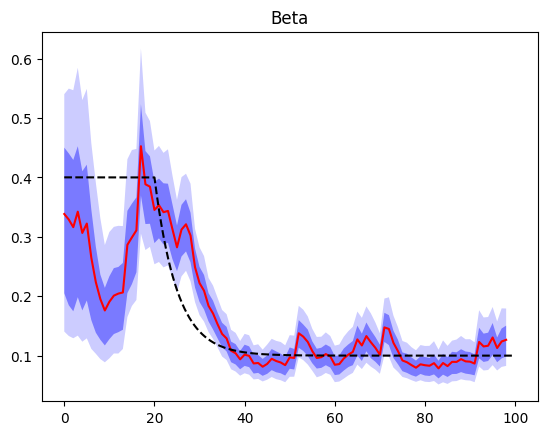

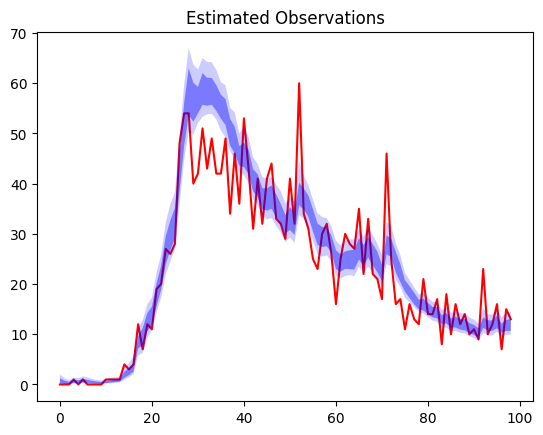

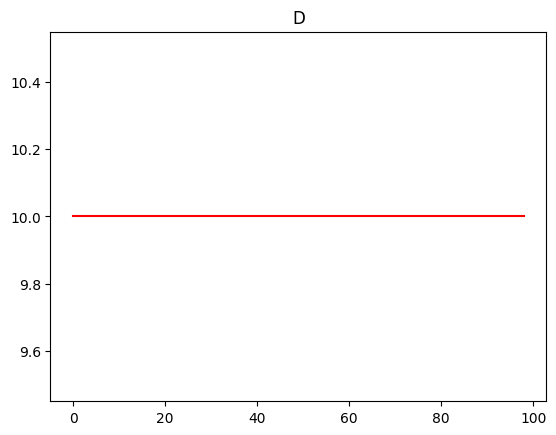

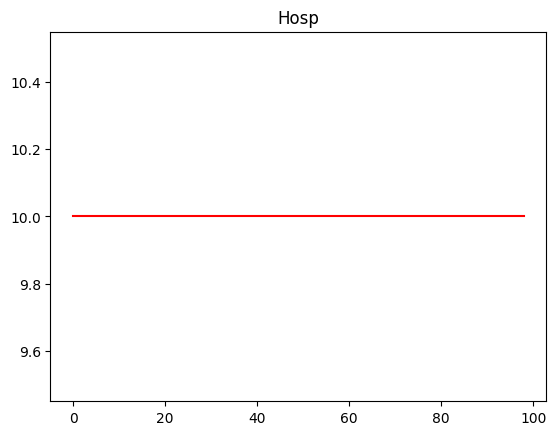

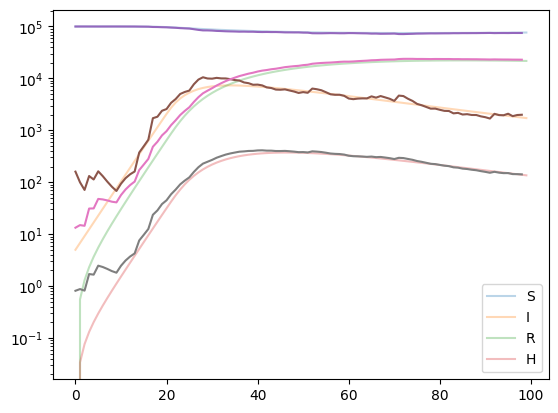

In [4]:
beta_quantiles = pd.read_csv('../datasets/beta_quantiles.csv').to_numpy()
beta_quantiles = np.delete(beta_quantiles,0,1)

plt.title("Beta")

pf_beta = pd.read_csv('../datasets/average_beta.csv').to_numpy()
pf_beta = np.delete(pf_beta,0,1)
plt.fill_between(np.arange(0,99), beta_quantiles[:,3], beta_quantiles[:,22-3], facecolor='blue', zorder=10,alpha = 0.2)
plt.fill_between(np.arange(0,99), beta_quantiles[:,6], beta_quantiles[:,22-6], facecolor='blue', zorder=11,alpha = 0.4)
plt.plot(pf_beta,color="red",zorder=12)
plt.plot(beta_ts,np.array(betas),linestyle="dashed",zorder=12,color='black')
plt.show()

# pf_state = pd.read_csv('../datasets/ESTIMATED_STATE.csv').to_numpy()
# pf_state = np.delete(pf_state,0,1)

# plt.yscale('log')
# plt.title("State")
# plt.plot(pf_state)
# labels = ['S','I','R','H']
# for i in range(4):
#     plt.plot(sol.y[i,:],label = labels[i],alpha = 0.3)
# plt.legend()
# plt.savefig('State.png')

# plt.show()

real_data = pd.read_csv('../datasets/SIRH_SIM_DATA.csv').to_numpy()
real_data = np.delete(real_data,0,1)

estimated_data = pd.read_csv('../datasets/particle_observation.csv').to_numpy()
estimated_data = np.delete(estimated_data,0,1)

plt.title("Estimated Observations")

plt.fill_between(np.arange(0,99), estimated_data[:,3], estimated_data[:,22-3], facecolor='blue', zorder=10,alpha = 0.2)
plt.fill_between(np.arange(0,99), estimated_data[:,6], estimated_data[:,22-6], facecolor='blue', zorder=11,alpha = 0.4)

plt.plot(np.arange(0,99),real_data[0:99],color='red')
plt.show()

pf_eta = pd.read_csv('../datasets/average_eta.csv').to_numpy()
pf_eta = np.delete(pf_eta,0,1)
eta_quantiles = pd.read_csv('../datasets/eta_quantiles.csv').to_numpy()
eta_quantiles = np.delete(eta_quantiles,0,1)

plt.title("D")

plt.fill_between(np.arange(0,99), eta_quantiles[:,3], eta_quantiles[:,22-3], facecolor='blue', zorder=10,alpha = 0.2)
plt.fill_between(np.arange(0,99), eta_quantiles[:,6], eta_quantiles[:,22-6], facecolor='blue', zorder=11,alpha = 0.4)
plt.plot(pf_eta,color="red",zorder=12)

plt.show()


pf_gamma = pd.read_csv('../datasets/average_gamma.csv').to_numpy()
pf_gamma = np.delete(pf_gamma,0,1)
gamma_quantiles = pd.read_csv('../datasets/gamma_quantiles.csv').to_numpy()
gamma_quantiles = np.delete(gamma_quantiles,0,1)

plt.title("Hosp")

plt.fill_between(np.arange(0,99), gamma_quantiles[:,3], gamma_quantiles[:,22-3], facecolor='blue', zorder=10,alpha = 0.2)
plt.fill_between(np.arange(0,99), gamma_quantiles[:,6], gamma_quantiles[:,22-6], facecolor='blue', zorder=11,alpha = 0.4)
plt.plot(pf_gamma,color="red",zorder=12)
plt.show()


pf_state = pd.read_csv('../datasets/ESTIMATED_STATE.csv').to_numpy()
pf_state = np.delete(pf_state,0,1)

plt.yscale('log')
labels = ['S','I','R','H','Obvs'] 
for i in range(4): 
    plt.plot(sol.y[i,:],label = labels[i],alpha = 0.3)

plt.plot(pf_state)
plt.legend()
plt.show()


